# Proyecto NLP E3 - Análisis de Noticias Financieras

In [63]:
# ==============================================================================
# SETUP - Instalación de Dependencias y Configuración
# ==============================================================================

# Instalación de librerías (descomentar si es necesario)
#!pip install pandas tqdm seaborn nltk scikit-learn gensim matplotlib numpy transformers torch tensorflow imbalanced-learn

import warnings
warnings.filterwarnings('ignore')

# Imports principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os
import random
import re
import string

# Crear directorios si no existen
os.makedirs('data', exist_ok=True)
os.makedirs('data_processed', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('charts', exist_ok=True)

# Configuración de reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Configuración de visualización
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("=" * 60)
print("SETUP COMPLETADO")
print("=" * 60)
print("\nEstructura de carpetas:")
print("  📁 data/              - Datasets originales e intermedios")
print("  📁 data_processed/    - Datos procesados (CSV, NPZ)")
print("  📁 models/            - Modelos entrenados y vectorizadores")
print("  📁 charts/            - Gráficos y visualizaciones")

SETUP COMPLETADO

Estructura de carpetas:
  📁 data/              - Datasets originales e intermedios
  📁 data_processed/    - Datos procesados (CSV, NPZ)
  📁 models/            - Modelos entrenados y vectorizadores
  📁 charts/            - Gráficos y visualizaciones


---
# Parte 1: Preparación de Datos

## 1.1 Carga del Dataset Original

In [58]:
# ==============================================================================
# 1.1 CARGA DEL DATASET ORIGINAL
# ==============================================================================

# Cargar dataset original
df_original = pd.read_csv('data/initial_data.csv')

print("=" * 60)
print("DATASET ORIGINAL CARGADO")
print("=" * 60)
print(f"\nTotal de noticias: {len(df_original)}")
print(f"Columnas: {list(df_original.columns)}")

print("\nDistribución de sentimientos:")
print(df_original['Sentiment'].value_counts())

print("\nPrimeras filas del dataset:")
df_original.head()

DATASET ORIGINAL CARGADO

Total de noticias: 5842
Columnas: ['Sentence', 'Sentiment']

Distribución de sentimientos:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Primeras filas del dataset:


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## 1.2 Mezcla de Datos - Creación de Noticias Incorrectas

In [59]:
# ==============================================================================
# 1.2 MEZCLA DE DATOS - CREACIÓN DE NOTICIAS INCORRECTAS
# ==============================================================================

def extraer_fragmentos(noticia):
    """
    Extrae fragmentos de una noticia dividiendo por comas o puntos.
    Esto permite crear mezclas más naturales de textos.
    """
    # Primero intentar dividir por comas
    fragmentos = [p.strip() for p in noticia.split(',') if p.strip()]
    
    # Si no hay suficientes fragmentos, dividir por puntos
    if len(fragmentos) <= 1:
        fragmentos = [p.strip() for p in noticia.split('.') if p.strip()]
    
    return fragmentos


def crear_mezclas_opuestas(df_positive, df_negative, num_mezclas):
    """
    Crea noticias incorrectas mezclando fragmentos de noticias 
    con sentimientos opuestos (positivo + negativo).
    
    Args:
        df_positive: DataFrame con noticias positivas
        df_negative: DataFrame con noticias negativas
        num_mezclas: Número de noticias incorrectas a crear
    
    Returns:
        DataFrame con noticias mezcladas etiquetadas como 'incorrecta'
    """
    noticias_mezcladas = []
    
    print(f"\nCreando {num_mezclas} mezclas de sentimientos opuestos...")
    
    for i in range(num_mezclas):
        if (i + 1) % 1000 == 0:
            print(f"  Procesadas {i + 1}/{num_mezclas}...")
        
        # Seleccionar una noticia positiva y una negativa aleatoriamente
        idx_pos = random.randint(0, len(df_positive) - 1)
        idx_neg = random.randint(0, len(df_negative) - 1)
        
        noticia_pos = df_positive.iloc[idx_pos]['Sentence']
        noticia_neg = df_negative.iloc[idx_neg]['Sentence']
        
        # Extraer fragmentos de cada noticia
        frag_pos = extraer_fragmentos(noticia_pos)
        frag_neg = extraer_fragmentos(noticia_neg)
        
        # Seleccionar 1-2 fragmentos de cada noticia
        if len(frag_pos) > 0 and len(frag_neg) > 0:
            num_pos = min(random.randint(1, 2), len(frag_pos))
            num_neg = min(random.randint(1, 2), len(frag_neg))
            
            fragmentos_seleccionados = (
                random.sample(frag_pos, num_pos) + 
                random.sample(frag_neg, num_neg)
            )
            
            # Mezclar el orden de los fragmentos
            random.shuffle(fragmentos_seleccionados)
            
            # Unir fragmentos
            noticia_mezclada = ', '.join(fragmentos_seleccionados)
            if noticia_mezclada and noticia_mezclada[-1] not in '.!?':
                noticia_mezclada += '.'
            
            # Asignar sentimiento aleatorio (ya que es inconsistente)
            sentiment = random.choice(['positive', 'negative'])
            
            noticias_mezcladas.append({
                'Sentence': noticia_mezclada,
                'Sentiment': sentiment,
                'Etiqueta': 'incorrecta'
            })
    
    return pd.DataFrame(noticias_mezcladas)


# Verificar si ya existe el dataset mezclado
if os.path.exists('data/dataset_mezclado_final.csv'):
    print("Dataset mezclado ya existe. Cargando...")
    df_mezclado = pd.read_csv('data/dataset_mezclado_final.csv')
else:
    print("Creando dataset mezclado desde cero...")
    
    # Crear copia para noticias correctas (50%)
    df_correctas = df_original.copy()
    df_correctas['Etiqueta'] = 'correcta'
    
    # Separar noticias por sentimiento
    df_positive = df_original[df_original['Sentiment'] == 'positive']
    df_negative = df_original[df_original['Sentiment'] == 'negative']
    
    print(f"\nNoticias positivas disponibles: {len(df_positive)}")
    print(f"Noticias negativas disponibles: {len(df_negative)}")
    
    # Crear el mismo número de noticias incorrectas que correctas
    num_mezclas = len(df_correctas)
    df_incorrectas = crear_mezclas_opuestas(df_positive, df_negative, num_mezclas)
    
    # Combinar datasets
    df_mezclado = pd.concat([df_correctas, df_incorrectas], ignore_index=True)
    
    # Mezclar aleatoriamente
    df_mezclado = df_mezclado.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    # Guardar dataset mezclado
    df_mezclado.to_csv('data/dataset_mezclado_final.csv', index=False, encoding='utf-8')
    print(f"\nDataset guardado en 'data/dataset_mezclado_final.csv'")

# Mostrar estadísticas
print("\n" + "=" * 60)
print("ESTADÍSTICAS DEL DATASET MEZCLADO")
print("=" * 60)
print(f"Total de filas: {len(df_mezclado)}")
print(f"Noticias correctas: {len(df_mezclado[df_mezclado['Etiqueta'] == 'correcta'])} ({len(df_mezclado[df_mezclado['Etiqueta'] == 'correcta'])/len(df_mezclado)*100:.1f}%)")
print(f"Noticias incorrectas: {len(df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'])} ({len(df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'])/len(df_mezclado)*100:.1f}%)")

print(f"\nDistribución de sentimientos en noticias CORRECTAS:")
print(df_mezclado[df_mezclado['Etiqueta'] == 'correcta']['Sentiment'].value_counts())

print(f"\nDistribución de sentimientos en noticias INCORRECTAS:")
print(df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta']['Sentiment'].value_counts())

Dataset mezclado ya existe. Cargando...

ESTADÍSTICAS DEL DATASET MEZCLADO
Total de filas: 11684
Noticias correctas: 5842 (50.0%)
Noticias incorrectas: 5842 (50.0%)

Distribución de sentimientos en noticias CORRECTAS:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Distribución de sentimientos en noticias INCORRECTAS:
Sentiment
negative    2946
positive    2896
Name: count, dtype: int64


In [64]:
# Mostrar ejemplos de noticias correctas e incorrectas
print("=" * 60)
print("EJEMPLOS DE NOTICIAS")
print("=" * 60)

print("\n[NOTICIA CORRECTA]")
ejemplo_correcta = df_mezclado[df_mezclado['Etiqueta'] == 'correcta'].iloc[0]
print(f"Sentimiento: {ejemplo_correcta['Sentiment']}")
print(f"Texto: {ejemplo_correcta['Sentence'][:300]}{'...' if len(ejemplo_correcta['Sentence']) > 300 else ''}")

print("\n" + "-" * 60)

print("\n[NOTICIA INCORRECTA - Ejemplo 1]")
ejemplo_inc1 = df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'].iloc[0]
print(f"Sentimiento asignado: {ejemplo_inc1['Sentiment']}")
print(f"Texto mezclado: {ejemplo_inc1['Sentence'][:300]}{'...' if len(ejemplo_inc1['Sentence']) > 300 else ''}")

print("\n[NOTICIA INCORRECTA - Ejemplo 2]")
ejemplo_inc2 = df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'].iloc[50]
print(f"Sentimiento asignado: {ejemplo_inc2['Sentiment']}")
print(f"Texto mezclado: {ejemplo_inc2['Sentence'][:300]}{'...' if len(ejemplo_inc2['Sentence']) > 300 else ''}")

EJEMPLOS DE NOTICIAS

[NOTICIA CORRECTA]
Sentimiento: neutral
Texto: The presentation material can be viewed on the company 's website in English after the conference .

------------------------------------------------------------

[NOTICIA INCORRECTA - Ejemplo 1]
Sentimiento asignado: positive
Texto mezclado: mining stocks, 5 m ) in cost savings on an annual basis, The plan is estimated to generate some EUR 5 million ( USD 6.

[NOTICIA INCORRECTA - Ejemplo 2]
Sentimiento asignado: positive
Texto mezclado: Walter Investment Management Corp Receives a Sell from Compass Point $WAC http://stks, 6 mn from EUR 10, co/c1IvX.


## 1.3 Análisis Exploratorio de Datos (EDA)

In [95]:
# ==============================================================================
# 1.4 ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ==============================================================================

# Cargar dataset desde CSV
df = pd.read_csv('data/dataset_mezclado_final.csv')

print("=" * 60)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 60)
print(f"\nDataset cargado desde 'data/dataset_mezclado_final.csv'")

# Información básica del dataset
print("\n1. ESTRUCTURA DEL DATASET")
print("-" * 60)
print(f"Total de filas: {len(df)}")
print(f"Columnas: {list(df.columns)}")
print(f"\nTipos de datos:")
print(df.dtypes)

# Valores nulos
print("\n2. VALORES NULOS")
print("-" * 60)
nulos = df.isnull().sum()
if nulos.sum() == 0:
    print("No hay valores nulos en el dataset")
else:
    print(nulos[nulos > 0])

# Distribuciones
print("\n3. DISTRIBUCIONES DE VARIABLES CATEGÓRICAS")
print("-" * 60)

for col in ['Sentiment', 'Etiqueta']:
    if col in df.columns:
        counts = df[col].value_counts()
        pcts = (counts / len(df) * 100).round(2)
        print(f"\n{col}:")
        for val in counts.index:
            print(f"  {val}: {counts[val]} ({pcts[val]}%)")

# Longitud de oraciones
print("\n4. ESTADÍSTICAS DE LONGITUD")
print("-" * 60)
df['sentence_length'] = df['Sentence'].str.split().str.len()
print(df['sentence_length'].describe().round(2))

ANÁLISIS EXPLORATORIO DE DATOS

Dataset cargado desde 'data/dataset_mezclado_final.csv'

1. ESTRUCTURA DEL DATASET
------------------------------------------------------------
Total de filas: 11684
Columnas: ['Sentence', 'Sentiment', 'Etiqueta']

Tipos de datos:
Sentence     object
Sentiment    object
Etiqueta     object
dtype: object

2. VALORES NULOS
------------------------------------------------------------
No hay valores nulos en el dataset

3. DISTRIBUCIONES DE VARIABLES CATEGÓRICAS
------------------------------------------------------------

Sentiment:
  positive: 4748 (40.64%)
  negative: 3806 (32.57%)
  neutral: 3130 (26.79%)

Etiqueta:
  correcta: 5842 (50.0%)
  incorrecta: 5842 (50.0%)

4. ESTADÍSTICAS DE LONGITUD
------------------------------------------------------------
count    11684.00
mean        23.62
std         11.46
min          2.00
25%         15.00
50%         22.00
75%         30.00
max         84.00
Name: sentence_length, dtype: float64


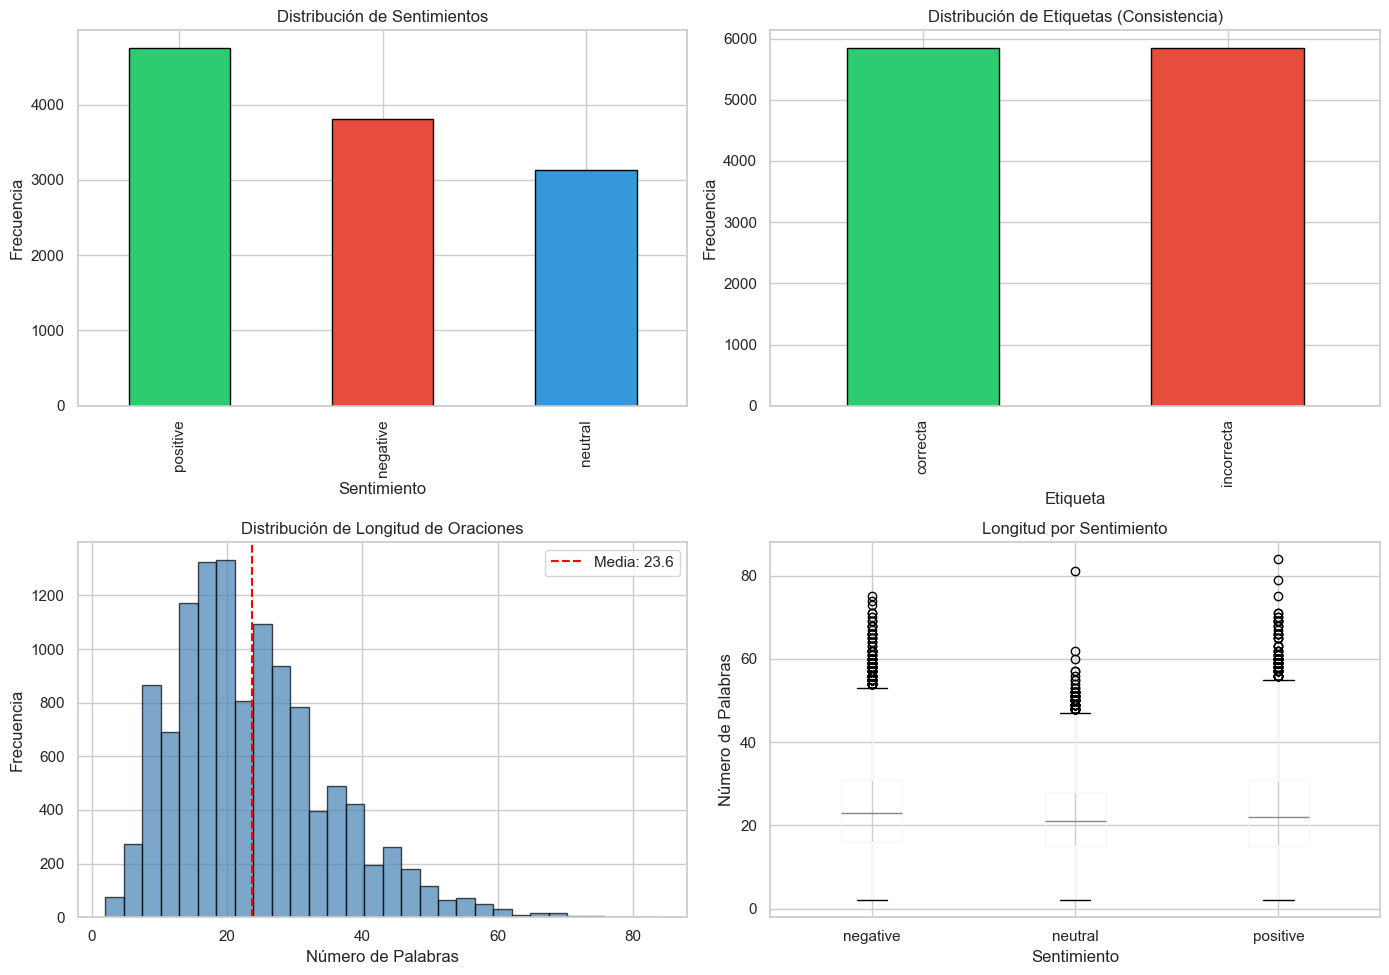


Gráfico guardado en 'charts/01_eda_distributions.png'


In [96]:
# Visualizaciones del EDA
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis Exploratorio del Dataset', fontsize=14, fontweight='bold')

# 1. Distribución de sentimientos
ax1 = axes[0, 0]
sent_counts = df['Sentiment'].value_counts()
colors_sent = {'positive': '#2ecc71', 'neutral': '#3498db', 'negative': '#e74c3c'}
sent_counts.plot(kind='bar', ax=ax1, color=[colors_sent.get(x, 'gray') for x in sent_counts.index], edgecolor='black')
ax1.set_title('Distribución de Sentimientos')
ax1.set_xlabel('Sentimiento')
ax1.set_ylabel('Frecuencia')

# 2. Distribución de etiquetas (consistencia)
ax2 = axes[0, 1]
etiq_counts = df['Etiqueta'].value_counts()
colors_etiq = {'correcta': '#2ecc71', 'incorrecta': '#e74c3c'}
etiq_counts.plot(kind='bar', ax=ax2, color=[colors_etiq.get(x, 'gray') for x in etiq_counts.index], edgecolor='black')
ax2.set_title('Distribución de Etiquetas (Consistencia)')
ax2.set_xlabel('Etiqueta')
ax2.set_ylabel('Frecuencia')

# 3. Distribución de longitud de oraciones
ax3 = axes[1, 0]
df['sentence_length'].hist(bins=30, ax=ax3, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(df['sentence_length'].mean(), color='red', linestyle='--', label=f'Media: {df["sentence_length"].mean():.1f}')
ax3.set_title('Distribución de Longitud de Oraciones')
ax3.set_xlabel('Número de Palabras')
ax3.set_ylabel('Frecuencia')
ax3.legend()

# 4. Boxplot de longitud por sentimiento
ax4 = axes[1, 1]
df.boxplot(column='sentence_length', by='Sentiment', ax=ax4)
ax4.set_title('Longitud por Sentimiento')
ax4.set_xlabel('Sentimiento')
ax4.set_ylabel('Número de Palabras')
plt.suptitle('')  # Remove automatic title from boxplot

plt.tight_layout()
plt.savefig('charts/01_eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en 'charts/01_eda_distributions.png'")

ANÁLISIS CRUZADO: Sentimiento vs Etiqueta

Conteo absoluto:
Etiqueta   correcta  incorrecta    All
Sentiment                             
negative        860        2946   3806
neutral        3130           0   3130
positive       1852        2896   4748
All            5842        5842  11684

Porcentaje por sentimiento:
Etiqueta   correcta  incorrecta
Sentiment                      
negative      22.60       77.40
neutral      100.00        0.00
positive      39.01       60.99


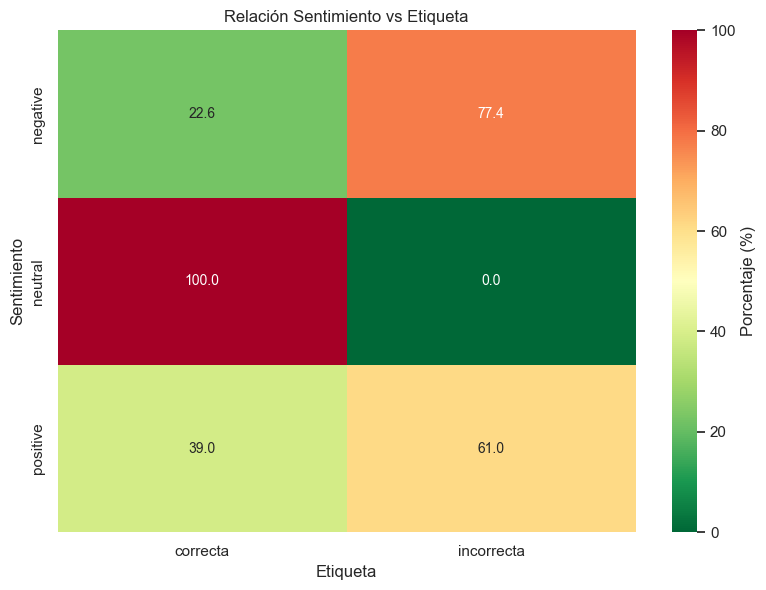


Gráfico guardado en 'charts/02_heatmap_sentiment_etiqueta.png'


In [97]:
# Análisis cruzado: Sentimiento vs Etiqueta
print("=" * 60)
print("ANÁLISIS CRUZADO: Sentimiento vs Etiqueta")
print("=" * 60)

# Tabla cruzada
crosstab = pd.crosstab(df['Sentiment'], df['Etiqueta'], margins=True)
print("\nConteo absoluto:")
print(crosstab)

crosstab_pct = pd.crosstab(df['Sentiment'], df['Etiqueta'], normalize='index') * 100
print("\nPorcentaje por sentimiento:")
print(crosstab_pct.round(2))

# Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax,
            cbar_kws={'label': 'Porcentaje (%)'})
ax.set_title('Relación Sentimiento vs Etiqueta')
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Sentimiento')
plt.tight_layout()
plt.savefig('charts/02_heatmap_sentiment_etiqueta.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en 'charts/02_heatmap_sentiment_etiqueta.png'")

## 1.4 Preprocesamiento de Texto

In [98]:
# ==============================================================================
# 1.5 PREPROCESAMIENTO DE TEXTO
# ==============================================================================

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Descargar recursos NLTK
print("Descargando recursos NLTK...")
for resource in ['punkt', 'punkt_tab', 'wordnet']:
    try:
        nltk.download(resource, quiet=True)
    except:
        pass
print("Recursos NLTK listos")

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()


def simple_tokenize(text):
    """Tokenización simple como fallback."""
    return re.findall(r"[\w']+", text.lower())


def preprocess_text(text, lemmatize=True):
    """
    Preprocesa texto: tokenización y lematización.
    
    Args:
        text: Texto a preprocesar
        lemmatize: Si True, aplica lematización
    
    Returns:
        Lista de tokens procesados
    """
    if pd.isna(text) or not str(text).strip():
        return []
    
    text = str(text).lower()
    
    # Tokenizar
    try:
        tokens = word_tokenize(text)
    except:
        tokens = simple_tokenize(text)
    
    # Lematizar si se indica
    if lemmatize:
        tokens = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
    
    return tokens


print("\n" + "=" * 60)
print("PREPROCESAMIENTO DE TEXTO")
print("=" * 60)

Descargando recursos NLTK...
Recursos NLTK listos

PREPROCESAMIENTO DE TEXTO


In [99]:
# Aplicar preprocesamiento al dataset
print("\n1. APLICANDO PREPROCESAMIENTO...")
print("-" * 60)

# Tokens lematizados (para BoW, TF-IDF)
df['tokens_lemmatized'] = df['Sentence'].apply(lambda x: preprocess_text(x, lemmatize=True))

# Tokens sin lematizar (para Word2Vec, FastText - preserva formas originales)
df['tokens_clean'] = df['Sentence'].apply(lambda x: preprocess_text(x, lemmatize=False))

# Convertir tokens a texto para vectorizadores
df['text_clean'] = df['tokens_lemmatized'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['text_tokens'] = df['tokens_clean'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

print("Preprocesamiento completado")

# Estadísticas
print("\n2. ESTADÍSTICAS DE PREPROCESAMIENTO")
print("-" * 60)

# Calcular tamaños de vocabulario
vocab_original = set(word for text in df['Sentence'].dropna() for word in simple_tokenize(str(text)))
vocab_lemmatized = set(token for tokens in df['tokens_lemmatized'] for token in tokens if isinstance(tokens, list))
vocab_clean = set(token for tokens in df['tokens_clean'] for token in tokens if isinstance(tokens, list))

print(f"Vocabulario original: {len(vocab_original)} palabras")
print(f"Vocabulario lematizado: {len(vocab_lemmatized)} palabras ({(1-len(vocab_lemmatized)/len(vocab_original))*100:.1f}% reducción)")
print(f"Vocabulario sin lematizar: {len(vocab_clean)} palabras")

# Longitud promedio de tokens
mean_orig = df['Sentence'].str.split().str.len().mean()
mean_lemm = df['tokens_lemmatized'].apply(len).mean()
print(f"\nLongitud promedio original: {mean_orig:.1f} palabras")
print(f"Longitud promedio procesada: {mean_lemm:.1f} tokens")
print(f"Reducción: {(1-mean_lemm/mean_orig)*100:.1f}%")

# Ejemplo de transformación
print("\n3. EJEMPLO DE TRANSFORMACIÓN")
print("-" * 60)
idx_ejemplo = 0
print(f"Original: {df['Sentence'].iloc[idx_ejemplo][:100]}...")
print(f"Tokens lematizados: {df['tokens_lemmatized'].iloc[idx_ejemplo][:10]}...")
print(f"Tokens clean: {df['tokens_clean'].iloc[idx_ejemplo][:10]}...")


1. APLICANDO PREPROCESAMIENTO...
------------------------------------------------------------
Preprocesamiento completado

2. ESTADÍSTICAS DE PREPROCESAMIENTO
------------------------------------------------------------
Vocabulario original: 11531 palabras
Vocabulario lematizado: 12017 palabras (-4.2% reducción)
Vocabulario sin lematizar: 13503 palabras

Longitud promedio original: 23.6 palabras
Longitud promedio procesada: 25.8 tokens
Reducción: -9.1%

3. EJEMPLO DE TRANSFORMACIÓN
------------------------------------------------------------
Original: The presentation material can be viewed on the company 's website in English after the conference ....
Tokens lematizados: ['the', 'presentation', 'material', 'can', 'be', 'view', 'on', 'the', 'company', "'s"]...
Tokens clean: ['the', 'presentation', 'material', 'can', 'be', 'viewed', 'on', 'the', 'company', "'s"]...


In [100]:
# Guardar datos preprocesados
df.to_csv('data_processed/datos_preprocesados.csv', index=False)
print("Datos preprocesados guardados en 'data_processed/datos_preprocesados.csv'")

# Mostrar estructura final del dataframe
print("\n" + "=" * 60)
print("ESTRUCTURA FINAL DEL DATASET")
print("=" * 60)
print(f"\nColumnas: {list(df.columns)}")
print(f"Filas: {len(df)}")
df.head(2)

Datos preprocesados guardados en 'data_processed/datos_preprocesados.csv'

ESTRUCTURA FINAL DEL DATASET

Columnas: ['Sentence', 'Sentiment', 'Etiqueta', 'sentence_length', 'tokens_lemmatized', 'tokens_clean', 'text_clean', 'text_tokens']
Filas: 11684


,Sentence,Sentiment,Etiqueta,sentence_length,tokens_lemmatized,tokens_clean,text_clean,text_tokens
0,The presentation material can be viewed on the...,neutral,correcta,17,"[the, presentation, material, can, be, view, o...","[the, presentation, material, can, be, viewed,...",the presentation material can be view on the c...,the presentation material can be viewed on the...
1,"mining stocks, 5 m ) in cost savings on an ann...",positive,incorrecta,25,"[mine, stock, ,, 5, m, ), in, cost, savings, o...","[mining, stocks, ,, 5, m, ), in, cost, savings...","mine stock , 5 m ) in cost savings on an annua...","mining stocks , 5 m ) in cost savings on an an..."


---
# Parte 2: Extracción de Features


## 2.1 Bag of Words (BoW)

In [101]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear vectorizador BoW
bow_vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.95)
X_bow = bow_vectorizer.fit_transform(df['text_clean'])

# Guardar
with open('models/bow_vectorizer.pkl', 'wb') as f:
    pickle.dump(bow_vectorizer, f)
np.save('data_processed/X_bow.npy', X_bow.toarray())

print(f'BoW: {X_bow.shape[0]} documentos × {X_bow.shape[1]} features')

BoW: 11684 documentos × 5000 features


## 2.2 TF-IDF

In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_clean'])

# Guardar
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
np.save('data_processed/X_tfidf.npy', X_tfidf.toarray())

print(f'TF-IDF: {X_tfidf.shape[0]} documentos × {X_tfidf.shape[1]} features')

TF-IDF: 11684 documentos × 5000 features


## 2.3 Word Embeddings (Word2Vec y FastText)

In [103]:
from gensim.models import Word2Vec, FastText

# Preparar corpus
corpus = df['text_tokens'].tolist()

# Entrenar Word2Vec
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4, seed=RANDOM_STATE)
w2v_model.save('models/word2vec.model')

# Entrenar FastText
ft_model = FastText(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4, seed=RANDOM_STATE)
ft_model.save('models/fasttext.model')

print(f'Word2Vec: {len(w2v_model.wv)} palabras, dim={w2v_model.wv.vector_size}')
print(f'FastText: {len(ft_model.wv)} palabras, dim={ft_model.wv.vector_size}')

Word2Vec: 83 palabras, dim=100
FastText: 83 palabras, dim=100


## 2.4 Preparación de Secuencias para Deep Learning

In [104]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parámetros
MAX_VOCAB = 5000
MAX_LEN = 100

# Tokenizer de Keras
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_clean'])

# Convertir a secuencias y aplicar padding
sequences = tokenizer.texts_to_sequences(df['text_clean'])
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Crear matrices de embeddings
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
embedding_dim = 100

# Matriz Word2Vec
embedding_w2v = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size and word in w2v_model.wv:
        embedding_w2v[idx] = w2v_model.wv[word]

# Matriz FastText
embedding_ft = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_ft[idx] = ft_model.wv[word]
        except:
            pass

# Guardar todo
np.savez('data_processed/sequences.npz', sequences=X_seq)
np.save('models/embedding_w2v.npy', embedding_w2v)
np.save('models/embedding_ft.npy', embedding_ft)
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Guardar config
config = {'vocab_size': vocab_size, 'max_len': MAX_LEN, 'embedding_dim': embedding_dim}
with open('models/config.pkl', 'wb') as f:
    pickle.dump(config, f)

print(f'Secuencias: {X_seq.shape}')
print(f'Embedding W2V: {embedding_w2v.shape}')
print(f'Embedding FT: {embedding_ft.shape}')

Secuencias: (11684, 100)
Embedding W2V: (5000, 100)
Embedding FT: (5000, 100)


---
# Parte 3: Tareas NLP

## 3.0 División Train/Validation/Test

DIVISIÓN TRAIN/VALIDATION/TEST

1. SPLITS PARA DETECCIÓN DE CONSISTENCIA
------------------------------------------------------------
Train: 8178 (70.0%)
Val:   1753 (15.0%)
Test:  1753 (15.0%)

2. SPLITS PARA ANÁLISIS DE SENTIMIENTO
------------------------------------------------------------
Train: 8178 (70.0%)
Val:   1753 (15.0%)
Test:  1753 (15.0%)

CLASS WEIGHTS PARA MANEJO DE DESBALANCE

--- CONSISTENCIA ---
Distribución: {np.int64(0): np.int64(4089), np.int64(1): np.int64(4089)}
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
pos_weight (PyTorch): 1.0000

--- SENTIMIENTO ---
Distribución: {np.int64(0): np.int64(2664), np.int64(1): np.int64(2191), np.int64(2): np.int64(3323)}
Class weights: {0: np.float64(1.0232732732732732), 1: np.float64(1.2441807393884072), 2: np.float64(0.8203430634968402)}


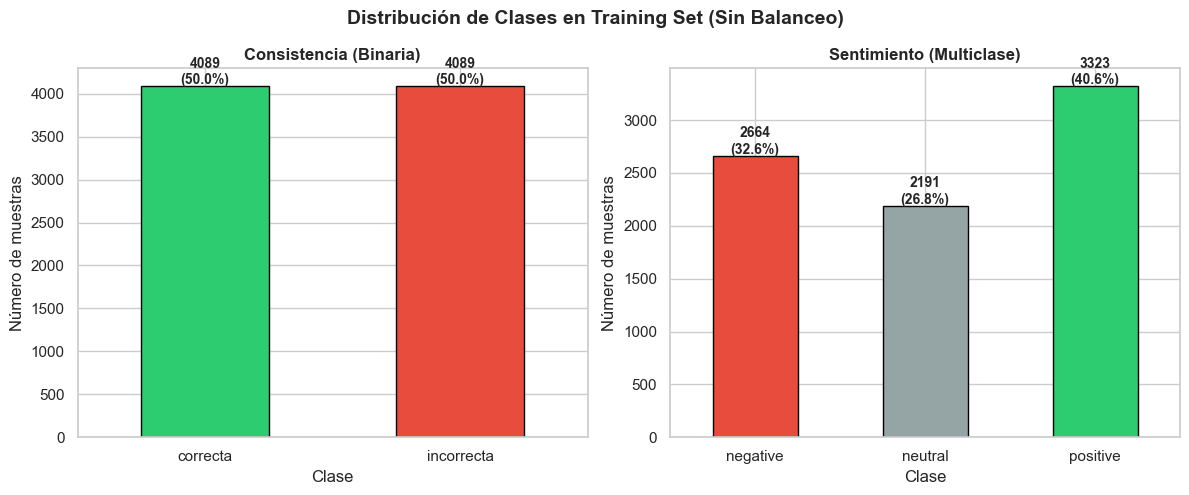


[Usaremos class_weight en los modelos para manejar el desbalance]


In [105]:
# ==============================================================================
# 3.0 DIVISIÓN TRAIN/VALIDATION/TEST + CLASS WEIGHTS
# ==============================================================================

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

def create_splits(df, target_col, prefix, test_size=0.3, val_ratio=0.5):
    """
    Crea splits estratificados para una tarea de clasificación.
    """
    # Filtrar filas válidas
    df_valid = df.dropna(subset=[target_col, 'text_clean'])
    df_valid = df_valid[df_valid['text_clean'].str.strip() != '']
    
    # Train/temp split (70/30)
    train, temp = train_test_split(
        df_valid, 
        test_size=test_size, 
        stratify=df_valid[target_col], 
        random_state=RANDOM_STATE
    )
    
    # Val/test split (15/15)
    val, test = train_test_split(
        temp, 
        test_size=val_ratio, 
        stratify=temp[target_col], 
        random_state=RANDOM_STATE
    )
    
    # Guardar splits
    train.to_csv(f'data_processed/{prefix}_train.csv', index=False)
    val.to_csv(f'data_processed/{prefix}_val.csv', index=False)
    test.to_csv(f'data_processed/{prefix}_test.csv', index=False)
    
    return train, val, test


print("=" * 60)
print("DIVISIÓN TRAIN/VALIDATION/TEST")
print("=" * 60)

# Splits para tarea de Consistencia
print("\n1. SPLITS PARA DETECCIÓN DE CONSISTENCIA")
print("-" * 60)
cons_train, cons_val, cons_test = create_splits(df, 'Etiqueta', 'consistency')
print(f"Train: {len(cons_train)} ({len(cons_train)/len(df)*100:.1f}%)")
print(f"Val:   {len(cons_val)} ({len(cons_val)/len(df)*100:.1f}%)")
print(f"Test:  {len(cons_test)} ({len(cons_test)/len(df)*100:.1f}%)")

# Splits para tarea de Sentimiento
print("\n2. SPLITS PARA ANÁLISIS DE SENTIMIENTO")
print("-" * 60)
sent_train, sent_val, sent_test = create_splits(df, 'Sentiment', 'sentiment')
print(f"Train: {len(sent_train)} ({len(sent_train)/len(df)*100:.1f}%)")
print(f"Val:   {len(sent_val)} ({len(sent_val)/len(df)*100:.1f}%)")
print(f"Test:  {len(sent_test)} ({len(sent_test)/len(df)*100:.1f}%)")

# ==============================================================================
# CÁLCULO DE CLASS WEIGHTS (sin resampling)
# ==============================================================================
print("\n" + "=" * 60)
print("CLASS WEIGHTS PARA MANEJO DE DESBALANCE")
print("=" * 60)

# Mapeos de etiquetas
cons_label_map = {'correcta': 0, 'incorrecta': 1}
sent_label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

# --- CONSISTENCIA ---
print("\n--- CONSISTENCIA ---")
y_cons_train = cons_train['Etiqueta'].map(cons_label_map).values
print(f"Distribución: {dict(zip(*np.unique(y_cons_train, return_counts=True)))}")

cons_class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_cons_train)
cons_class_weight_dict = {0: cons_class_weights[0], 1: cons_class_weights[1]}
cons_pos_weight = np.sum(y_cons_train == 0) / np.sum(y_cons_train == 1)

print(f"Class weights: {cons_class_weight_dict}")
print(f"pos_weight (PyTorch): {cons_pos_weight:.4f}")

# --- SENTIMIENTO ---
print("\n--- SENTIMIENTO ---")
y_sent_train = sent_train['Sentiment'].map(sent_label_map).values
print(f"Distribución: {dict(zip(*np.unique(y_sent_train, return_counts=True)))}")

sent_class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_sent_train)
sent_class_weight_dict = {0: sent_class_weights[0], 1: sent_class_weights[1], 2: sent_class_weights[2]}

print(f"Class weights: {sent_class_weight_dict}")

# ==============================================================================
# VISUALIZACIÓN: DISTRIBUCIÓN DE CLASES
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Distribución de Clases en Training Set (Sin Balanceo)', fontsize=14, fontweight='bold')

# Consistencia
ax1 = axes[0]
cons_counts = cons_train['Etiqueta'].value_counts()
colors_cons = ['#2ecc71', '#e74c3c']
cons_counts.plot(kind='bar', ax=ax1, color=colors_cons, edgecolor='black')
ax1.set_title('Consistencia (Binaria)', fontweight='bold')
ax1.set_xlabel('Clase')
ax1.set_ylabel('Número de muestras')
ax1.tick_params(axis='x', rotation=0)
for i, v in enumerate(cons_counts):
    ax1.text(i, v + 20, f'{v}\n({v/len(cons_train)*100:.1f}%)', ha='center', fontweight='bold')

# Sentimiento
ax2 = axes[1]
sent_counts = sent_train['Sentiment'].value_counts().reindex(['negative', 'neutral', 'positive'])
colors_sent = ['#e74c3c', '#95a5a6', '#2ecc71']
sent_counts.plot(kind='bar', ax=ax2, color=colors_sent, edgecolor='black')
ax2.set_title('Sentimiento (Multiclase)', fontweight='bold')
ax2.set_xlabel('Clase')
ax2.set_ylabel('Número de muestras')
ax2.tick_params(axis='x', rotation=0)
for i, v in enumerate(sent_counts):
    ax2.text(i, v + 20, f'{v}\n({v/len(sent_train)*100:.1f}%)', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('charts/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n[Usaremos class_weight en los modelos para manejar el desbalance]")

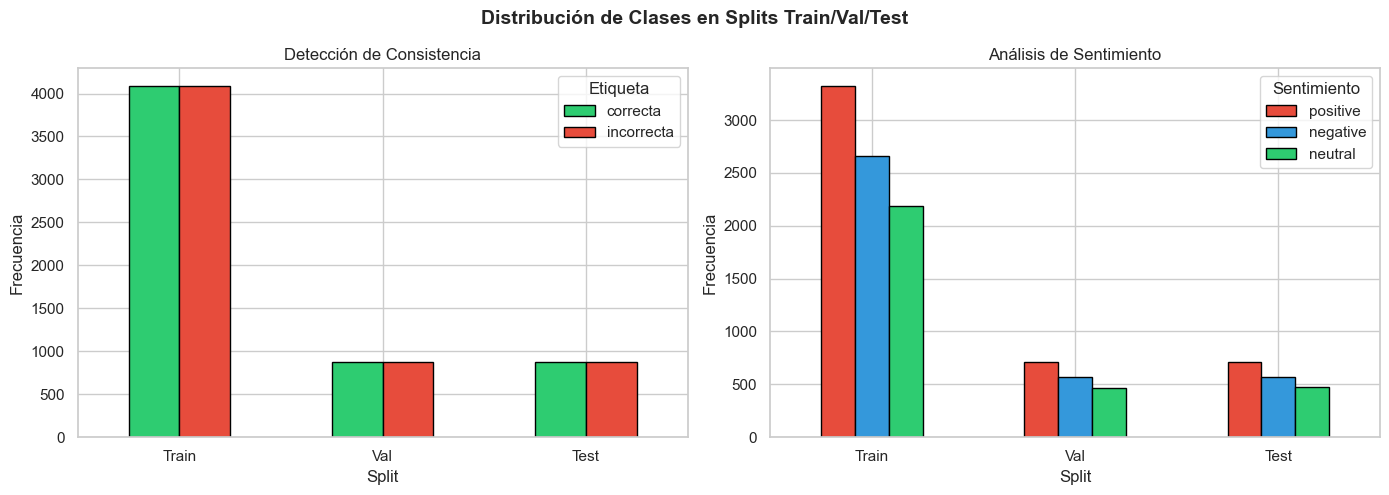


Gráfico guardado en 'charts/03_train_val_test_splits.png'

Archivos generados:
  - data_processed/consistency_train.csv
  - data_processed/consistency_val.csv
  - data_processed/consistency_test.csv
  - data_processed/sentiment_train.csv
  - data_processed/sentiment_val.csv
  - data_processed/sentiment_test.csv


In [106]:
# Visualización de los splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribución de Clases en Splits Train/Val/Test', fontsize=14, fontweight='bold')

# Consistencia
ax1 = axes[0]
splits_cons = {
    'Train': cons_train['Etiqueta'].value_counts(),
    'Val': cons_val['Etiqueta'].value_counts(),
    'Test': cons_test['Etiqueta'].value_counts()
}
df_cons_splits = pd.DataFrame(splits_cons).T
df_cons_splits.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax1.set_title('Detección de Consistencia')
ax1.set_xlabel('Split')
ax1.set_ylabel('Frecuencia')
ax1.legend(title='Etiqueta')
ax1.tick_params(axis='x', rotation=0)

# Sentimiento
ax2 = axes[1]
splits_sent = {
    'Train': sent_train['Sentiment'].value_counts(),
    'Val': sent_val['Sentiment'].value_counts(),
    'Test': sent_test['Sentiment'].value_counts()
}
df_sent_splits = pd.DataFrame(splits_sent).T
df_sent_splits.plot(kind='bar', ax=ax2, color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black')
ax2.set_title('Análisis de Sentimiento')
ax2.set_xlabel('Split')
ax2.set_ylabel('Frecuencia')
ax2.legend(title='Sentimiento')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('charts/03_train_val_test_splits.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en 'charts/03_train_val_test_splits.png'")
print("\nArchivos generados:")
print("  - data_processed/consistency_train.csv")
print("  - data_processed/consistency_val.csv")
print("  - data_processed/consistency_test.csv")
print("  - data_processed/sentiment_train.csv")
print("  - data_processed/sentiment_val.csv")
print("  - data_processed/sentiment_test.csv")

## 3.1 Detección de Consistencia

### 3.1.1 Shallow Learning (BoW)

In [107]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Cargar datos originales
cons_train = pd.read_csv('data_processed/consistency_train.csv')
cons_val = pd.read_csv('data_processed/consistency_val.csv')
cons_test = pd.read_csv('data_processed/consistency_test.csv')

# Vectorizar con BoW
with open('models/bow_vectorizer.pkl', 'rb') as f:
    bow_vec = pickle.load(f)

X_train = bow_vec.transform(cons_train['text_clean'])
X_val = bow_vec.transform(cons_val['text_clean'])
X_test = bow_vec.transform(cons_test['text_clean'])

# Etiquetas numéricas
y_train = cons_train['Etiqueta'].map(cons_label_map).values
y_val = cons_val['Etiqueta'].map(cons_label_map).values
y_test = cons_test['Etiqueta'].map(cons_label_map).values

print(f"Train: {len(cons_train)} muestras")
print(f"Distribución: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"\nClass weights: {cons_class_weight_dict}")
print(f"\nForma X_train: {X_train.shape}")

Train: 8178 muestras
Distribución: {np.int64(0): np.int64(4089), np.int64(1): np.int64(4089)}

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Forma X_train: (8178, 5000)


In [108]:
# Entrenar modelos shallow con class_weight para manejar desbalance

shallow_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, 
                                              class_weight=cons_class_weight_dict),
    'LinearSVC': LinearSVC(max_iter=1000, random_state=RANDOM_STATE, 
                           class_weight=cons_class_weight_dict),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, 
                                           class_weight=cons_class_weight_dict)
}

shallow_results = {}
for name, model in shallow_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    shallow_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }
    print(f'{name}: Acc={shallow_results[name]["Accuracy"]:.4f}, F1={shallow_results[name]["F1"]:.4f}')

df_shallow = pd.DataFrame(shallow_results).T
print('\nResultados Shallow Learning (Consistencia):')
print(df_shallow.round(4))

# Guardar mejor modelo
best_shallow = df_shallow['F1'].idxmax()
with open('models/consistency_shallow_best.pkl', 'wb') as f:
    pickle.dump(shallow_models[best_shallow], f)
print(f'\nMejor modelo: {best_shallow}')

LogisticRegression: Acc=0.7045, F1=0.7116
LinearSVC: Acc=0.6805, F1=0.6865
RandomForest: Acc=0.6326, F1=0.5577

Resultados Shallow Learning (Consistencia):
                    Accuracy      F1
LogisticRegression    0.7045  0.7116
LinearSVC             0.6805  0.6865
RandomForest          0.6326  0.5577

Mejor modelo: LogisticRegression


### 3.1.2 Deep Learning (LSTM, CNN)

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout, Conv1D, 
                                     GlobalMaxPooling1D, GlobalAveragePooling1D,
                                     Bidirectional, Input, Attention)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.random.set_seed(RANDOM_STATE)

# Cargar embeddings y config
embedding_w2v = np.load('models/embedding_w2v.npy')

with open('models/config.pkl', 'rb') as f:
    config = pickle.load(f)

MAX_LEN = config['max_len']

# Crear tokenizer y ajustar solo con datos de entrenamiento
tokenizer_cons = Tokenizer(num_words=config['vocab_size'], oov_token='<OOV>')
tokenizer_cons.fit_on_texts(cons_train['text_clean'])

# Tokenizar cada split
X_train_seq = pad_sequences(tokenizer_cons.texts_to_sequences(cons_train['text_clean']), 
                            maxlen=MAX_LEN, padding='post', truncating='post')
X_val_seq = pad_sequences(tokenizer_cons.texts_to_sequences(cons_val['text_clean']), 
                          maxlen=MAX_LEN, padding='post', truncating='post')
X_test_seq = pad_sequences(tokenizer_cons.texts_to_sequences(cons_test['text_clean']), 
                           maxlen=MAX_LEN, padding='post', truncating='post')

print(f"X_train_seq: {X_train_seq.shape}, y_train: {len(y_train)}")
print(f"X_val_seq: {X_val_seq.shape}, y_val: {len(y_val)}")
print(f"X_test_seq: {X_test_seq.shape}, y_test: {len(y_test)}")
print(f"\nClass weights para Keras: {cons_class_weight_dict}")

X_train_seq: (8178, 100), y_train: 8178
X_val_seq: (1753, 100), y_val: 1753
X_test_seq: (1753, 100), y_test: 1753

Class weights para Keras: {0: np.float64(1.0), 1: np.float64(1.0)}


In [114]:
# Modelo LSTM con Bidireccionalidad y Atención (Bi-LSTM + Attention)
def create_lstm(vocab_size, embed_dim, max_len, embedding_matrix, trainable=False):
    # API Funcional de Keras para permitir conexiones complejas
    inputs = Input(shape=(max_len,))
    
    # Capa de Embedding
    x = Embedding(vocab_size, embed_dim, weights=[embedding_matrix], 
                  input_length=max_len, trainable=trainable)(inputs)
    
    # Bi-LSTM con return_sequences=True para obtener todos los estados ocultos
    lstm_out = Bidirectional(LSTM(64, return_sequences=True))(x)
    
    # Mecanismo de Atención
    # Proyecciones para query y value
    query = Dense(128)(lstm_out)
    value = Dense(128)(lstm_out)
    attention_out = Attention()([query, value])
    
    # Colapsar la secuencia en un vector de contexto
    context_vector = GlobalAveragePooling1D()(attention_out)
    
    # Capas densas (Head)
    x = Dropout(0.3)(context_vector)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Modelo CNN Multi-Kernel (CNN Kim) para clasificación de texto
# Arquitectura que detecta n-gramas de diferentes tamaños simultáneamente
def create_cnn(vocab_size, embed_dim, max_len, embedding_matrix, trainable=False):
    from tensorflow.keras.layers import Concatenate
    
    # Entrada
    inputs = Input(shape=(max_len,))
    
    # Capa de Embedding
    embedding = Embedding(vocab_size, embed_dim, weights=[embedding_matrix], 
                          input_length=max_len, trainable=trainable)(inputs)
    
    # Bloque Convolucional Multicanal (Ramas Paralelas)
    # Cada rama detecta n-gramas de diferente tamaño
    conv_outputs = []
    
    # Rama 1: kernel_size=2 (bigramas - pares de palabras)
    conv2 = Conv1D(filters=128, kernel_size=2, activation='relu')(embedding)
    pool2 = GlobalMaxPooling1D()(conv2)
    conv_outputs.append(pool2)
    
    # Rama 2: kernel_size=3 (trigramas)
    conv3 = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
    pool3 = GlobalMaxPooling1D()(conv3)
    conv_outputs.append(pool3)
    
    # Rama 3: kernel_size=4 (4-gramas)
    conv4 = Conv1D(filters=128, kernel_size=4, activation='relu')(embedding)
    pool4 = GlobalMaxPooling1D()(conv4)
    conv_outputs.append(pool4)
    
    # Rama 4: kernel_size=5 (5-gramas - contexto más largo)
    conv5 = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding)
    pool5 = GlobalMaxPooling1D()(conv5)
    conv_outputs.append(pool5)
    
    # Fusión: Concatenar todas las salidas de pooling
    merged = Concatenate()(conv_outputs)
    
    # Capas de Clasificación
    x = Dropout(0.3)(merged)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Crear modelo con API Funcional
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [115]:
# Entrenar modelos deep learning con class_weight

deep_results = {}

# LSTM
tf.keras.backend.clear_session()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lstm_model = create_lstm(config['vocab_size'], config['embedding_dim'], config['max_len'], embedding_w2v)
lstm_model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val),
               epochs=15, batch_size=32, callbacks=[early_stop], 
               class_weight=cons_class_weight_dict, verbose=0)
y_pred_lstm = (lstm_model.predict(X_test_seq, verbose=0) > 0.5).astype(int).flatten()
deep_results['LSTM'] = {'Accuracy': accuracy_score(y_test, y_pred_lstm), 'F1': f1_score(y_test, y_pred_lstm)}
print(f'LSTM: Acc={deep_results["LSTM"]["Accuracy"]:.4f}, F1={deep_results["LSTM"]["F1"]:.4f}')
lstm_model.save('models/consistency_lstm.h5')

# CNN
tf.keras.backend.clear_session()
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
cnn_model = create_cnn(config['vocab_size'], config['embedding_dim'], config['max_len'], embedding_w2v)
cnn_model.fit(X_train_seq, y_train, validation_data=(X_val_seq, y_val),
              epochs=15, batch_size=32, callbacks=[early_stop], 
              class_weight=cons_class_weight_dict, verbose=0)
y_pred_cnn = (cnn_model.predict(X_test_seq, verbose=0) > 0.5).astype(int).flatten()
deep_results['CNN'] = {'Accuracy': accuracy_score(y_test, y_pred_cnn), 'F1': f1_score(y_test, y_pred_cnn)}
print(f'CNN: Acc={deep_results["CNN"]["Accuracy"]:.4f}, F1={deep_results["CNN"]["F1"]:.4f}')
cnn_model.save('models/consistency_cnn.h5')

df_deep = pd.DataFrame(deep_results).T
print('\nResultados Deep Learning (Consistencia):')
print(df_deep.round(4))

LSTM: Acc=0.6212, F1=0.5626


CNN: Acc=0.5716, F1=0.5726

Resultados Deep Learning (Consistencia):
      Accuracy      F1
LSTM    0.6212  0.5626
CNN     0.5716  0.5726


### 3.1.3 Comparativa de Consistencia

Comparativa Detección de Consistencia:
                    Accuracy      F1
LogisticRegression    0.7045  0.7116
LinearSVC             0.6805  0.6865
CNN                   0.5853  0.6008
LSTM                  0.6241  0.5930
RandomForest          0.6326  0.5577


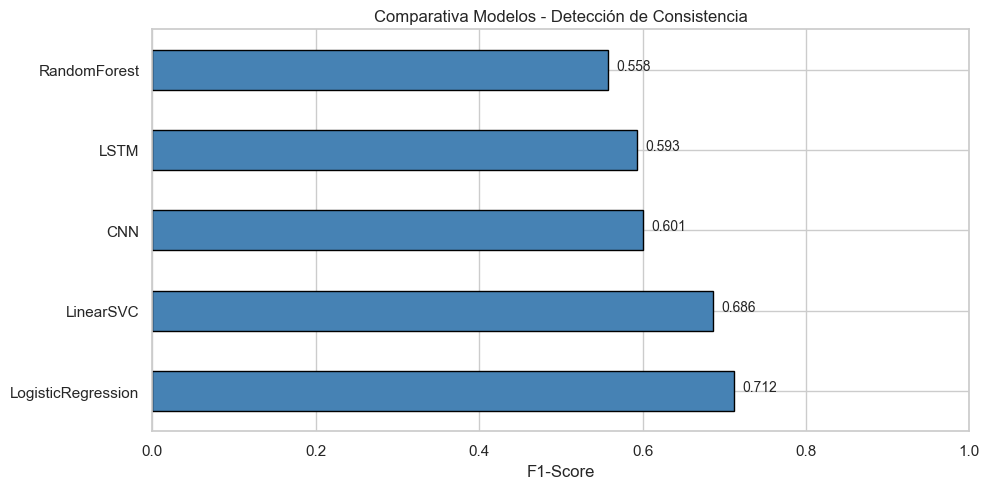

In [112]:
# Consolidar resultados de consistencia
all_cons_results = {**shallow_results, **deep_results}
df_cons = pd.DataFrame(all_cons_results).T.sort_values('F1', ascending=False)

print('Comparativa Detección de Consistencia:')
print(df_cons.round(4))

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
df_cons['F1'].plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('F1-Score')
ax.set_title('Comparativa Modelos - Detección de Consistencia')
ax.set_xlim(0, 1)
for i, v in enumerate(df_cons['F1']):
    ax.text(v + 0.01, i, f'{v:.3f}')
plt.tight_layout()
plt.savefig('charts/consistency_comparison.png', dpi=150)
plt.show()

# Guardar resultados
df_cons.to_csv('models/consistency_results.csv')

## 3.2 Análisis de Sentimiento

### 3.2.1 Shallow Learning (TF-IDF)

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Cargar datos ORIGINALES (sin balancear)
sent_train = pd.read_csv('data_processed/sentiment_train.csv')
sent_val = pd.read_csv('data_processed/sentiment_val.csv')
sent_test = pd.read_csv('data_processed/sentiment_test.csv')

print(f"Train: {len(sent_train)} muestras")
print(f"Distribución train: {sent_train['Sentiment'].value_counts().to_dict()}")

# Vectorizar con TF-IDF
with open('models/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vec = pickle.load(f)

X_train_tf = tfidf_vec.transform(sent_train['text_clean'])
X_val_tf = tfidf_vec.transform(sent_val['text_clean'])
X_test_tf = tfidf_vec.transform(sent_test['text_clean'])

# Mapear sentimientos a valores numéricos
y_train_s = sent_train['Sentiment'].map(sent_label_map).values
y_val_s = sent_val['Sentiment'].map(sent_label_map).values
y_test_s = sent_test['Sentiment'].map(sent_label_map).values

print(f"\nDistribución y_train_s: {dict(zip(*np.unique(y_train_s, return_counts=True)))}")
print(f"Class weights: {sent_class_weight_dict}")

# Entrenar modelos Shallow con class_weight
print("\n" + "=" * 60)
print("SHALLOW LEARNING - SENTIMIENTO (con class_weight)")
print("=" * 60)

shallow_sent_models = {
    'NaiveBayes': MultinomialNB(),  # NB no soporta class_weight, pero es robusto a desbalance
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE, 
                                              class_weight=sent_class_weight_dict),
    'LinearSVC': LinearSVC(max_iter=1000, random_state=RANDOM_STATE, 
                           class_weight=sent_class_weight_dict)
}

shallow_sent_results = {}
for name, model in shallow_sent_models.items():
    model.fit(X_train_tf, y_train_s)
    y_pred = model.predict(X_test_tf)
    
    shallow_sent_results[name] = {
        'Accuracy': accuracy_score(y_test_s, y_pred),
        'F1_macro': f1_score(y_test_s, y_pred, average='macro'),
        'F1_weighted': f1_score(y_test_s, y_pred, average='weighted')
    }
    print(f'{name}: Acc={shallow_sent_results[name]["Accuracy"]:.4f}, F1_macro={shallow_sent_results[name]["F1_macro"]:.4f}')

print("\nResultados Shallow Learning (Sentimiento):")
print(pd.DataFrame(shallow_sent_results).T.round(4))

Train: 8176 muestras
Distribución train: {'positive': 3323, 'negative': 2663, 'neutral': 2190}

Distribución y_train_s: {np.int64(0): np.int64(2663), np.int64(1): np.int64(2190), np.int64(2): np.int64(3323)}
Class weights: {0: np.float64(1.023407184879209), 1: np.float64(1.2444444444444445), 2: np.float64(0.8201424415688635)}

SHALLOW LEARNING - SENTIMIENTO (con class_weight)
NaiveBayes: Acc=0.5334, F1_macro=0.5265
LogisticRegression: Acc=0.5608, F1_macro=0.5673
LinearSVC: Acc=0.5579, F1_macro=0.5665

Resultados Shallow Learning (Sentimiento):
                    Accuracy  F1_macro  F1_weighted
NaiveBayes            0.5334    0.5265       0.5244
LogisticRegression    0.5608    0.5673       0.5600
LinearSVC             0.5579    0.5665       0.5588


### 3.2.2 Deep Learning (LSTM + FastText)

In [93]:
# Cargar FastText embeddings
embedding_ft = np.load('models/embedding_ft.npy')

# Crear tokenizer para sentimiento
tokenizer_sent = Tokenizer(num_words=config['vocab_size'], oov_token='<OOV>')
tokenizer_sent.fit_on_texts(sent_train['text_clean'])

# Tokenizar cada split
X_train_sent = pad_sequences(tokenizer_sent.texts_to_sequences(sent_train['text_clean']), 
                             maxlen=config['max_len'], padding='post', truncating='post')
X_val_sent = pad_sequences(tokenizer_sent.texts_to_sequences(sent_val['text_clean']), 
                           maxlen=config['max_len'], padding='post', truncating='post')
X_test_sent = pad_sequences(tokenizer_sent.texts_to_sequences(sent_test['text_clean']), 
                            maxlen=config['max_len'], padding='post', truncating='post')

print(f"X_train_sent: {X_train_sent.shape}, y_train_s: {len(y_train_s)}")
print(f"X_val_sent: {X_val_sent.shape}, y_val_s: {len(y_val_s)}")
print(f"X_test_sent: {X_test_sent.shape}, y_test_s: {len(y_test_s)}")
print(f"\nClass weights para Keras: {sent_class_weight_dict}")

# Modelo LSTM multiclase
def create_lstm_multiclass(vocab_size, embed_dim, max_len, embedding_matrix, num_classes=3, trainable=False):
    model = Sequential([
        Embedding(vocab_size, embed_dim, weights=[embedding_matrix], 
                  input_length=max_len, trainable=trainable),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

X_train_sent: (8176, 100), y_train_s: 8176
X_val_sent: (1752, 100), y_val_s: 1752
X_test_sent: (1753, 100), y_test_s: 1753

Class weights para Keras: {0: np.float64(1.023407184879209), 1: np.float64(1.2444444444444445), 2: np.float64(0.8201424415688635)}


In [94]:
# Entrenar LSTM con diferentes configuraciones de embedding
# Usando class_weight para manejar desbalance

lstm_configs = [
    ('LSTM_Frozen', embedding_ft, False),
    ('LSTM_FineTuned', embedding_ft, True),
    ('LSTM_Scratch', None, True)
]

deep_sent_results = {}

for name, emb_matrix, trainable in lstm_configs:
    tf.keras.backend.clear_session()
    
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    if emb_matrix is None:
        emb_matrix = np.random.randn(config['vocab_size'], config['embedding_dim']) * 0.01
    
    model = create_lstm_multiclass(config['vocab_size'], config['embedding_dim'], 
                                   config['max_len'], emb_matrix, trainable=trainable)
    
    model.fit(X_train_sent, y_train_s, validation_data=(X_val_sent, y_val_s),
              epochs=15, batch_size=32, callbacks=[early_stop], 
              class_weight=sent_class_weight_dict, verbose=0)
    
    y_pred = np.argmax(model.predict(X_test_sent, verbose=0), axis=1)
    deep_sent_results[name] = {
        'Accuracy': accuracy_score(y_test_s, y_pred),
        'F1_macro': f1_score(y_test_s, y_pred, average='macro'),
        'F1_weighted': f1_score(y_test_s, y_pred, average='weighted')
    }
    
    print(f'{name}: Acc={deep_sent_results[name]["Accuracy"]:.4f}, F1_macro={deep_sent_results[name]["F1_macro"]:.4f}')
    
    if name == 'LSTM_Frozen':
        model.save('models/sentiment_lstm.h5')

df_deep_sent = pd.DataFrame(deep_sent_results).T
print('\nResultados LSTM (Sentimiento):')
print(df_deep_sent.round(4))

LSTM_Frozen: Acc=0.2681, F1_macro=0.1410
LSTM_FineTuned: Acc=0.3257, F1_macro=0.1638
LSTM_Scratch: Acc=0.2681, F1_macro=0.1410

Resultados LSTM (Sentimiento):
                Accuracy  F1_macro  F1_weighted
LSTM_Frozen       0.2681    0.1410       0.1134
LSTM_FineTuned    0.3257    0.1638       0.1601
LSTM_Scratch      0.2681    0.1410       0.1134


### 3.2.3 Embeddings Contextuales (BERT, RoBERTa)

In [86]:
# ==========================================
# IMPORTS Y CONFIGURACIÓN PARA TRANSFORMERS
# ==========================================

import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Configuración del dispositivo
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {DEVICE}")

# Hiperparámetros para Transformers
MAX_LEN_TRANSFORMER = 128
BATCH_SIZE_TR = 16
LEARNING_RATE = 2e-5
EPOCHS_TR = 3

# Dataset personalizado para Transformers
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# Función para crear DataLoaders
def create_transformer_loaders(train_df, val_df, test_df, tokenizer, max_len, batch_size):
    # Mapeo de labels
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}

    train_texts = train_df['text_clean'].tolist()
    val_texts = val_df['text_clean'].tolist()
    test_texts = test_df['text_clean'].tolist()

    train_labels = train_df['Sentiment'].map(label_map).tolist()
    val_labels = val_df['Sentiment'].map(label_map).tolist()
    test_labels = test_df['Sentiment'].map(label_map).tolist()

    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, max_len)
    val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, max_len)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader, label_map


print("✓ Imports y configuración para Transformers completados")

Dispositivo: cpu
✓ Imports y configuración para Transformers completados


In [87]:
from tqdm import tqdm
from transformers import BertTokenizer, BertForSequenceClassification

def train_epoch(model, loader, optimizer, scheduler, device, desc='Training'):
    model.train()
    total_loss, preds, labels = 0, [], []
    progress_bar = tqdm(loader, desc=desc, leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()
        outputs = model(input_ids=batch['input_ids'].to(device),
                       attention_mask=batch['attention_mask'].to(device),
                       labels=batch['label'].to(device))
        outputs.loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += outputs.loss.item()
        preds.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())
        labels.extend(batch['label'].tolist())
        progress_bar.set_postfix({'loss': f'{outputs.loss.item():.4f}'})
    return total_loss / len(loader), accuracy_score(labels, preds)


def evaluate_transformer(model, loader, device, desc='Evaluating'):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc=desc, leave=False):
            outputs = model(input_ids=batch['input_ids'].to(device),
                           attention_mask=batch['attention_mask'].to(device))
            preds.extend(torch.argmax(outputs.logits, dim=1).cpu().tolist())
            labels.extend(batch['label'].tolist())
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro'),
        'f1_weighted': f1_score(labels, preds, average='weighted'),
        'predictions': preds, 'labels': labels
    }

print("✓ Funciones de Transformers preparadas")

✓ Funciones de Transformers preparadas


In [88]:
# ==============================================================================
# BERT - FINE-TUNING
# ==============================================================================

print("\nCargando BERT...")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
bert_model.to(DEVICE)

bert_train_loader, bert_val_loader, bert_test_loader, _ = create_transformer_loaders(
    sent_train, sent_val, sent_test, bert_tokenizer, MAX_LEN_TRANSFORMER, BATCH_SIZE_TR)

# Entrenar
total_steps = len(bert_train_loader) * EPOCHS_TR
bert_optimizer = AdamW(bert_model.parameters(), lr=LEARNING_RATE)
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                                  num_warmup_steps=int(0.1*total_steps),
                                                  num_training_steps=total_steps)

print(f"\nEntrenando BERT ({EPOCHS_TR} épocas)...")
for epoch in range(EPOCHS_TR):
    print(f'\n--- Época {epoch+1}/{EPOCHS_TR} ---')
    train_loss, train_acc = train_epoch(bert_model, bert_train_loader, 
                                         bert_optimizer, bert_scheduler, DEVICE,
                                         desc=f'BERT Época {epoch+1}')
    val_results = evaluate_transformer(bert_model, bert_val_loader, DEVICE)
    print(f"Época {epoch+1}: Train Loss={train_loss:.4f}, Val Acc={val_results['accuracy']:.4f}, Val F1={val_results['f1_macro']:.4f}")

# Evaluar en test
bert_results = evaluate_transformer(bert_model, bert_test_loader, DEVICE)
print(f"\n[BERT TEST] Acc={bert_results['accuracy']:.4f}, F1_macro={bert_results['f1_macro']:.4f}")
torch.save(bert_model.state_dict(), 'models/bert_sentiment.pt')


Cargando BERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Entrenando BERT (3 épocas)...

--- Época 1/3 ---


Época 1: Train Loss=0.9448, Val Acc=0.5953, Val F1=0.6062

--- Época 2/3 ---


Época 2: Train Loss=0.7509, Val Acc=0.5999, Val F1=0.6136

--- Época 3/3 ---


Época 3: Train Loss=0.6373, Val Acc=0.5947, Val F1=0.5995



[BERT TEST] Acc=0.6115, F1_macro=0.6150


In [ ]:
# ==============================================================================
# RoBERTa - FINE-TUNING
# ==============================================================================

print("\nCargando RoBERTa...")
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
roberta_model.to(DEVICE)

roberta_train_loader, roberta_val_loader, roberta_test_loader, _ = create_transformer_loaders(
    sent_train, sent_val, sent_test, roberta_tokenizer, MAX_LEN_TRANSFORMER, BATCH_SIZE_TR)

# Entrenar
total_steps = len(roberta_train_loader) * EPOCHS_TR
roberta_optimizer = AdamW(roberta_model.parameters(), lr=LEARNING_RATE)
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer,
                                                     num_warmup_steps=int(0.1*total_steps),
                                                     num_training_steps=total_steps)

print(f"\nEntrenando RoBERTa ({EPOCHS_TR} épocas)...")
for epoch in range(EPOCHS_TR):
    print(f'\n--- Época {epoch+1}/{EPOCHS_TR} ---')
    train_loss, train_acc = train_epoch(roberta_model, roberta_train_loader,
                                         roberta_optimizer, roberta_scheduler, DEVICE,
                                         desc=f'RoBERTa Época {epoch+1}')
    val_results = evaluate_transformer(roberta_model, roberta_val_loader, DEVICE)
    print(f"Época {epoch+1}: Train Loss={train_loss:.4f}, Val Acc={val_results['accuracy']:.4f}, Val F1={val_results['f1_macro']:.4f}")

# Evaluar en test
roberta_results = evaluate_transformer(roberta_model, roberta_test_loader, DEVICE)
print(f"\n[RoBERTa TEST] Acc={roberta_results['accuracy']:.4f}, F1_macro={roberta_results['f1_macro']:.4f}")
torch.save(roberta_model.state_dict(), 'models/roberta_sentiment.pt')

### 3.2.4 Comparativa de Sentimiento

Consolidación de resultados de todos los modelos: Shallow (TF-IDF), Deep (LSTM+FastText) y Transformers (BERT, RoBERTa).

COMPARATIVA COMPLETA - ANÁLISIS DE SENTIMIENTO
                    Accuracy  F1_macro  F1_weighted       Tipo_Embedding
RoBERTa               0.5392    0.4723       0.5254           Contextual
BERT                  0.5126    0.4322       0.4941           Contextual
LogisticRegression    0.3326    0.3187       0.3404    Disperso (TF-IDF)
NaiveBayes            0.4392    0.2685       0.3609    Disperso (TF-IDF)
LinearSVC             0.2909    0.2546       0.2962    Disperso (TF-IDF)
LSTM_FineTuned        0.3362    0.1677       0.1692  Estático (FastText)
LSTM_Scratch          0.3362    0.1677       0.1692  Estático (FastText)
LSTM_Frozen           0.1699    0.0968       0.0494  Estático (FastText)


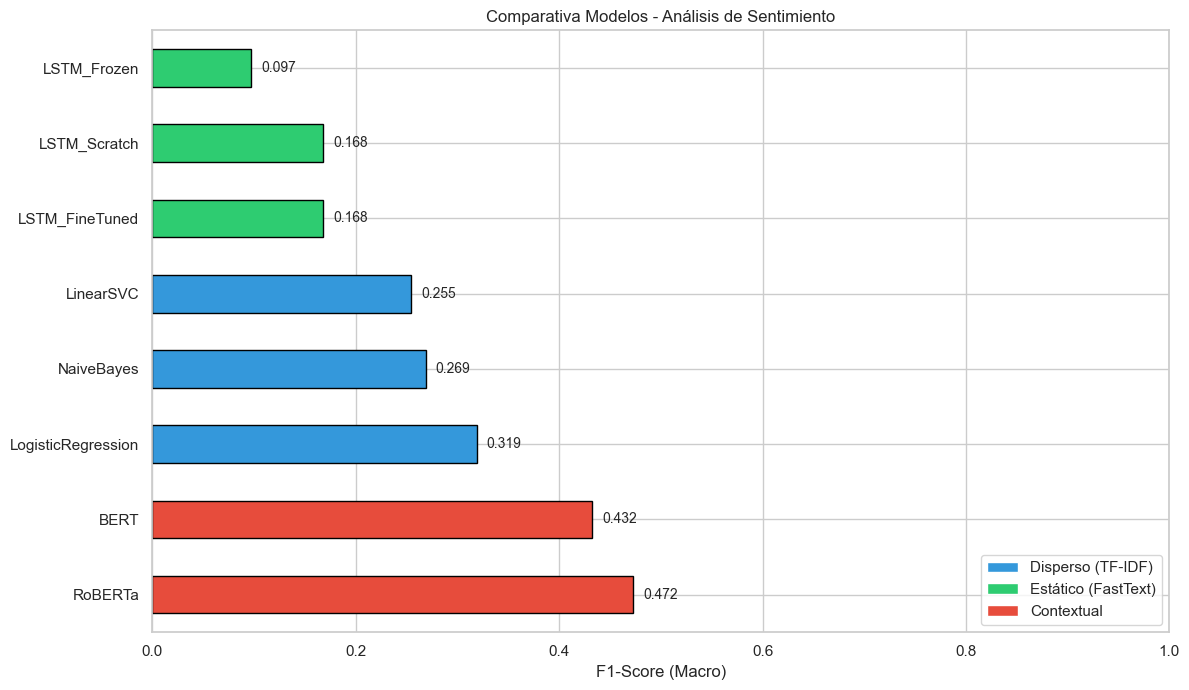

In [ ]:
# ==============================================================================
# COMPARATIVA COMPLETA - ANÁLISIS DE SENTIMIENTO
# ==============================================================================

# Añadir resultados de Transformers
transformer_sent_results = {
    'BERT': {
        'Accuracy': bert_results['accuracy'],
        'F1_macro': bert_results['f1_macro'],
        'F1_weighted': bert_results['f1_weighted']
    },
    'RoBERTa': {
        'Accuracy': roberta_results['accuracy'],
        'F1_macro': roberta_results['f1_macro'],
        'F1_weighted': roberta_results['f1_weighted']
    }
}

# Consolidar todos los resultados
all_sent_results = {
    **shallow_sent_results,
    **deep_sent_results,
    **transformer_sent_results
}

df_sent = pd.DataFrame(all_sent_results).T
df_sent['Tipo_Embedding'] = 'Estático'
df_sent.loc[['NaiveBayes', 'LogisticRegression', 'LinearSVC'], 'Tipo_Embedding'] = 'Disperso (TF-IDF)'
df_sent.loc[['LSTM_Frozen', 'LSTM_FineTuned', 'LSTM_Scratch'], 'Tipo_Embedding'] = 'Estático (FastText)'
df_sent.loc[['BERT', 'RoBERTa'], 'Tipo_Embedding'] = 'Contextual'

df_sent = df_sent.sort_values('F1_macro', ascending=False)

print('=' * 70)
print('COMPARATIVA COMPLETA - ANÁLISIS DE SENTIMIENTO')
print('=' * 70)
print(df_sent[['Accuracy', 'F1_macro', 'F1_weighted', 'Tipo_Embedding']].round(4))

# Guardar resultados
df_sent.to_csv('models/sentiment_results.csv')

# Visualización
fig, ax = plt.subplots(figsize=(12, 7))
colors = {'Disperso (TF-IDF)': '#3498db', 'Estático (FastText)': '#2ecc71', 'Contextual': '#e74c3c'}
bar_colors = [colors.get(df_sent.loc[idx, 'Tipo_Embedding'], 'gray') for idx in df_sent.index]

df_sent['F1_macro'].plot(kind='barh', ax=ax, color=bar_colors, edgecolor='black')
ax.set_xlabel('F1-Score (Macro)')
ax.set_title('Comparativa Modelos - Análisis de Sentimiento')
ax.set_xlim(0, 1)
for i, v in enumerate(df_sent['F1_macro']):
    ax.text(v + 0.01, i, f'{v:.3f}', va='center')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for l, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('charts/sentiment_comparison_final.png', dpi=150)
plt.show()